# **Assignment 2**
### *Programming for Quant and Computational Finance*
##### - Submission by *Dhyey Mavani (ddm2149)*

---
## **Simulation-Based Pricing**
---

Let the present time be 0. Let $t ≥ 0$ be the present or a future time, and $S_t$ the underlying asset value at time $t$. Let $r_S$ be the short rate process. Consider a European style derivative having a single payoff at its
maturity time $T$. Let $X$ be the its payoff of at time $T$. For example, for a European call option with strike $K$ on a stock, then $S_T$ is the terminal stock price and $X = max(S_T-K,0)$. In theory, the value of the option is given by $V = E[exp(-\int_0^Tr_Sds)X]$ where the expectation $E$ is taken under the risk-neutral measure.

Let $Y = exp(-∫_0^Tr_Sds)X$ be the discounted payoff. Then we have $V = E[Y]$. Under simulation-based pricing, one would simulate $Y_1, Y_2, ..., Y_N$. The value under $N$ simulations is given by $V_N = \frac{1}{N}(Y_1 + Y_2 + ... + Y_N)$, and a 95% confidence interval of this price is given by $[V_N-\frac{1.96*sd}{\sqrt{N}},V_N+\frac{1.96*sd}{\sqrt{N}}]$, where $sd$ is the sample standard deviation (ie. square root of the sample variance) computed from $Y_1, Y_2, ..., Y_N$.

Consider the Black-Scholes model settings on a stock $S_t$ where:

• the continuously compounded dividend rate is assumed to be constant $q$.

• the BS volatility is assumed to be constant $σ$.

• the short rate is deterministic and also a constant, $r_s$ = $r$.

In this case, $S_T = S_0*exp(∫(r_s-q-σ^2/2)+∫_0^TσdW_S)$ where $W_S$ is a standard Brownian motion.

Thus, we can generate samples of terminal stock price via $S_T = S_0*exp((r_s-q-σ^2/2)T+σ\sqrt{T}z)$ where $z$ is the standard normal random variate.

**a) Write a function to compute and return the theoretical BS price and delta of a European call option. The function inputs shall include: current stock price $S_0$, strike $K$, time to option expiry (in years) $T$, short rate $r$, the dividend rate $q$ and the volatility $\sigma$.**

In [ ]:
import numpy as np
from scipy.stats import norm

def bs_call_price_delta(S0, K, T, r, q, sigma):

    d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    price = S0*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    delta = np.exp(-q*T)*norm.cdf(d1)
    
    return price, delta


In [ ]:
# Example usage of theoretical function with given data
price, delta = bs_call_price_delta(180, 160, 0.25, 0.01, 0.015, 0.20)
print("Theoretical price: ", price)
print("Delta: ", delta)

Theoretical price:  20.743527985763706
Delta:  0.8845566261664979


**b) Write a function to compute the simulated price $V_N$ of a European call option. Besides the inputs as described part (a), the number of simulations $N$ shall also be an input. The function shall return $V_N$ and the 95% confidence interval**

In [ ]:
import numpy as np

def simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N):

    drift = (r - q - 0.5 * sigma ** 2) * T
    discount_factor = np.exp(-r * T)
    
    z = np.random.standard_normal(N)
    ST = S0 * np.exp(drift + sigma * np.sqrt(T) * z)
    payoff = np.maximum(ST - K, 0)
    
    V_N = discount_factor * np.mean(payoff)
    se = np.std(payoff, ddof=1) / np.sqrt(N)
    lower = V_N - 1.96 * se
    upper = V_N + 1.96 * se
    
    return V_N, (lower, upper)


In [ ]:
# Example to test the function and demonstrate the usage
V_N, conf_int = simulated_call_price_CI_generator(180, 160, 0.25, 0.01, 0.015, 0.20, 10000000)
print("Simulated price: ", V_N)
print("95% confidence interval: ", conf_int)

Simulated price:  20.73970535966762
95% confidence interval:  (20.729517437148797, 20.749893282186445)


---
## **Convergence and variance reduction**
---

Now take the following example data: $S_0 = 180$, $r = 0.01$, $K = 160$, $q = 0.015$, $σ = 0.20$, $T = 0.25$



**c) Use the example data to plot the simulated price $V_N$ against the number of simulations $N$ where $1 ≤ N ≤ 500000$. The figure shall also include a plot for (i) the upper bound (ie. $V_N+\frac{1.96*sd}{\sqrt{N}}$), (ii) lower bound (ie. $V_N-\frac{1.96*sd}{\sqrt{N}}$) with 95% confidence (iii) a flat line for the theoretical BS price. Label each of the lines properly.**

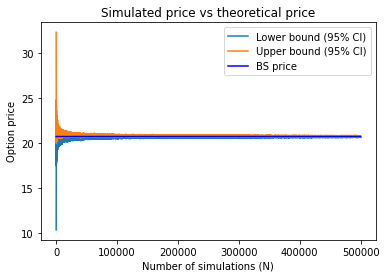

In [ ]:
import matplotlib.pyplot as plt

# Example data
S0 = 180
r = 0.01
K = 160
q = 0.015
sigma = 0.2
T = 0.25
N_sim = 500000
# Theoretical Price
bs_price, _ = bs_call_price_delta(180, 160, 0.25, 0.01, 0.015, 0.20)

# Set the range of simulations to plot
N_range = np.arange(1, N_sim+1, 10)

# Initialize the arrays to store the simulated prices and standard deviations
mc_prices = np.zeros(len(N_range))
mc_lowers = np.zeros(len(N_range))
mc_uppers = np.zeros(len(N_range))

# Compute the simulated prices and standard deviations for each number of simulations
for i in range(len(N_range)):
    mc_prices[i], (mc_lowers[i], mc_uppers[i]) = simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N_range[i])

# Plot the results
#plt.plot(N_range, mc_prices, label='Simulated price')
plt.plot(N_range, mc_lowers, label='Lower bound (95% CI)')
plt.plot(N_range, mc_uppers, label='Upper bound (95% CI)')
plt.plot(N_range, np.ones(len(N_range))*bs_price, 'blue', label='BS price')
plt.xlabel('Number of simulations (N)')
plt.ylabel('Option price')
plt.title('Simulated price vs theoretical price')
plt.legend()
plt.show()


**d) Enhance your function in part (b) to include an optional input flag for antithetical draw. If the flag is True, the simulated price $\tilde{V_N}$ will be computed with antithetical draws using $N$ random samples. If the flag is False, the simulated price $V_N$ is computed as in part (b) with $N$ random samples.**

In [ ]:
def enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N, antithetic=False):
    # Compute the drift and the discount factor
    drift = (r - q - 0.5 * sigma ** 2) * T
    discount_factor = np.exp(-r * T)

    # Generate standard normal random variables
    if antithetic:
        z1 = np.random.standard_normal(N)
        z2 = -z1
        z = np.concatenate([z1, z2])
    else:
        z = np.random.standard_normal(N)

    # Compute the simulated stock prices at expiry
    ST = S0 * np.exp(drift + sigma * np.sqrt(T) * z)

    # Compute the payoffs of the call option
    payoff = np.maximum(ST - K, 0)

    # Compute the simulated option prices
    if antithetic:
        V_N = discount_factor * np.mean(payoff)
    else:
        V_N = discount_factor * np.mean(payoff[:N])

    # Compute the standard error of the simulated option prices
    se = np.std(payoff, ddof=1) / np.sqrt(N)

    # Compute the 95% confidence interval of the simulated option prices
    lower = V_N - 1.96 * se
    upper = V_N + 1.96 * se

    return V_N, (lower, upper)




In [ ]:
S0 = 180
K = 160
T = 0.25
r = 0.01
q = 0.015
sigma = 0.2
N = 100000

# Example usage without antithetic draws 
VN, (lower, upper) = enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N, antithetic=False)
print(f"Simulated price: {VN:.4f}")
print(f"95% confidence interval: [{lower:.4f}, {upper:.4f}]")

# Example usage with antithetic draws
VN, (lower, upper) = enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N, antithetic=True)
print(f"Simulated price: {VN:.4f}")
print(f"95% confidence interval: [{lower:.4f}, {upper:.4f}]")

# Example usage of theoretical function with given data
price, delta = bs_call_price_delta(180, 160, 0.25, 0.01, 0.015, 0.20)
print("Theoretical price: ", price)
print("Delta: ", delta)



Simulated price: 20.7732
95% confidence interval: [20.6712, 20.8752]
Simulated price: 20.7466
95% confidence interval: [20.6447, 20.8485]
Theoretical price:  20.743527985763706
Delta:  0.8845566261664979


Now let’s compare the empirical distribution for $V_{2N}$ and $\tilde{V_N}$.

**e) Use the example data and your function in part (d) to generate 1000 simulated prices for $V_{2N}$ and $\tilde{V_N}$. Here set $N = 500000$. Chart the distribution of $V_{2N}$ and $\tilde{V_N}$ in the same figure. Compute and compare the sample variance of the 1000 simulated prices for $V_{2N}$ and $\tilde{V_N}$.**

We can see that $Var(V_{2N}) > Var(\tilde{V_N})$. This illustrates the power of using antithetical draw in this case. Not only does it reduce variance, we can do our analysis with a fewer number of simulations.


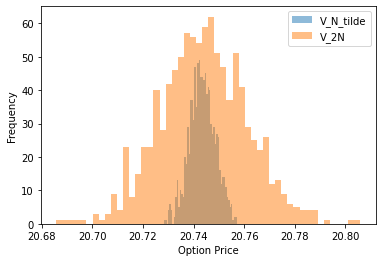

Sample variance of V_N_tilde: 0.00003
Sample variance of V_2N: 0.00029


In [ ]:
S0 = 180
K = 160
T = 0.25
r = 0.01
q = 0.015
sigma = 0.2
N = 500000
N_sim = 1000
N_range = np.arange(0, N_sim)


v_n_tilde = []
v_2n = []
for i in range(1000):
    v_n_tilde_i, _ = enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N, antithetic=True)
    v_n_tilde.append(v_n_tilde_i)
    
    v_2n_i, _ = enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, 2*N, antithetic=False)
    v_2n.append(v_2n_i)

import matplotlib.pyplot as plt

plt.hist(v_n_tilde, bins=50, alpha=0.5, label='V_N_tilde')
plt.hist(v_2n, bins=50, alpha=0.5, label='V_2N')
plt.legend(loc='upper right')
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.show()

# Compute the sample variances
var_V_n_tilde = np.var(v_n_tilde, ddof=1)
var_V_2n = np.var(v_2n, ddof=1)

print(f'Sample variance of V_N_tilde: {var_V_n_tilde:.5f}')
print(f'Sample variance of V_2N: {var_V_2n:.5f}')


---
## **Greek calculations**
---

There are two potential ways to compute the numerical delta of the option using MC simulation.

First the simulated price is a function of the current stock price. One can view $V_N$ as $V_N(S_0)$. With a small shift (say, $ε = 0.01S_0$) of the current stock price, one can compute the one-sided delta as:

$$Δ_1 = \frac{V_N(S_0+ε)-V_N(S_0)}{ε}$$

Another approach is that since random samples are already generated in computing $V_N(S_0)$, we may as well re-use these samples to estimate $V_N(S_0+ε)$. Suppose the standard normal random samples are $z_1, ..., z_N$. Let’s denote the simulated price computed from these samples by $V_N(S_0;z_1, ..., z_N)$. Then one can estimate the one-sided delta as:

$$Δ_2 = \frac{V_N(S_0+ε;z_1, ... , z_N) - V_N(S_0;z_1, ..., z_N)}{ε}$$

**f) Write a function to compute and return $∆_1$. Use the example data to call your function several times with different shifts. Comment if you get “good” Deltas. Does it converge to the theoretical delta?**

We can see from the results below that this method is not able to give us "good" deltas which I consider to be close to the theoretical delta value. We can see that we don't have a convergence to the theoretical delta in this case.

In [ ]:
def delta_1(S0, K, T, r, q, sigma, N, epsilon):
    V_N_S0, (_, __) = enhanced_simulated_call_price_CI_generator(S0, K, T, r, q, sigma, N)
    V_N_S0_plus_epsilon, (_, __) = enhanced_simulated_call_price_CI_generator(S0 + epsilon, K, T, r, q, sigma, N)
    delta = (V_N_S0_plus_epsilon - V_N_S0)/epsilon
    return delta


In [ ]:
S0 = 180
K = 160
T = 0.25
r = 0.01
q = 0.015
sigma = 0.2
N = 500000

# Example usage of theoretical function with given data
price, delta = bs_call_price_delta(180, 160, 0.25, 0.01, 0.015, 0.20)
print("Theoretical Delta: ", delta)

print(f"Delta_1 using epsilon = 0.5 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.5):.4f}")
print(f"Delta_1 using epsilon = 0.1 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.1):.4f}")
print(f"Delta_1 using epsilon = 0.05 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.05):.4f}")
print(f"Delta_1 using epsilon = 0.02 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.02):.4f}")
print(f"Delta_1 using epsilon = 0.01 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.01):.4f}")
print(f"Delta_1 using epsilon = 0.005 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.005):.4f}")
print(f"Delta_1 using epsilon = 0.0001 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.0001):.4f}")
print(f"Delta_1 using epsilon = 0.00001 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.00001):.4f}")
print(f"Delta_1 using epsilon = 0.000001 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.000001):.4f}")
print(f"Delta_1 using epsilon = 0.0000001 is: {delta_1(S0, K, T, r, q, sigma, N, epsilon=0.0000001):.4f}")

Theoretical Delta:  0.8845566261664979
Delta_1 using epsilon = 0.5 is: 0.8313
Delta_1 using epsilon = 0.1 is: 1.7501
Delta_1 using epsilon = 0.05 is: 1.7913
Delta_1 using epsilon = 0.02 is: 2.0860
Delta_1 using epsilon = 0.01 is: 3.0526
Delta_1 using epsilon = 0.005 is: -2.9905
Delta_1 using epsilon = 0.0001 is: 147.8730
Delta_1 using epsilon = 0.00001 is: 2791.4429
Delta_1 using epsilon = 0.000001 is: -18497.7926
Delta_1 using epsilon = 0.0000001 is: -132520.2386


**g) Write a function to compute and return $∆_2$. Use the example data to call your function several times with different shifts. Comment if you get “good” Deltas. Does it converge to the theoretical delta?**

We can see that this method is able to give us "good" delta values which we define as values which are comparable to the theoretical value of delta. Also, we can see from the examples run below that our delta_2 function outputs seem to converge to the theoretical delta as we decrease our epsilon.

In [ ]:
def delta_2(S0, K, T, r, q, sigma, N, epsilon):
    # Compute VN at S0
    z = np.random.standard_normal(N)
    ST = S0 * np.exp((r - q - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)
    payoff = np.maximum(ST - K, 0)
    VN_S0 = np.exp(-r * T) * np.mean(payoff)
    
    # Compute VN at S0 + epsilon using the same z samples
    ST_epsilon = (S0 + epsilon) * np.exp((r - q - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)
    payoff_epsilon = np.maximum(ST_epsilon - K, 0)
    VN_S0_epsilon = np.exp(-r * T) * np.mean(payoff_epsilon)
    
    # Compute delta
    delta = (VN_S0_epsilon - VN_S0) / epsilon
    
    return delta


In [ ]:
S0 = 180
K = 160
T = 0.25
r = 0.01
sigma = 0.2
N = 500000

# Example usage of theoretical function with given data
price, delta = bs_call_price_delta(180, 160, 0.25, 0.01, 0.015, 0.20)
print("Theoretical Delta: ", delta)

print(f"Delta_2 using epsilon = 0.5 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.5):.4f}")
print(f"Delta_2 using epsilon = 0.1 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.1):.4f}")
print(f"Delta_2 using epsilon = 0.05 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.05):.4f}")
print(f"Delta_2 using epsilon = 0.02 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.02):.4f}")
print(f"Delta_2 using epsilon = 0.01 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.01):.4f}")
print(f"Delta_2 using epsilon = 0.005 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.005):.4f}")
print(f"Delta_2 using epsilon = 0.0001 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.0001):.4f}")
print(f"Delta_2 using epsilon = 0.00001 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.00001):.4f}")
print(f"Delta_2 using epsilon = 0.000001 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.000001):.4f}")
print(f"Delta_2 using epsilon = 0.0000001 is: {delta_2(S0, K, T, r, q, sigma, N, epsilon=0.0000001):.4f}")

Theoretical Delta:  0.8845566261664979
Delta_2 using epsilon = 0.5 is: 0.8867
Delta_2 using epsilon = 0.1 is: 0.8855
Delta_2 using epsilon = 0.05 is: 0.8852
Delta_2 using epsilon = 0.02 is: 0.8854
Delta_2 using epsilon = 0.01 is: 0.8850
Delta_2 using epsilon = 0.005 is: 0.8847
Delta_2 using epsilon = 0.0001 is: 0.8842
Delta_2 using epsilon = 0.00001 is: 0.8849
Delta_2 using epsilon = 0.000001 is: 0.8848
Delta_2 using epsilon = 0.0000001 is: 0.8844


---
#### End of the Assignment
---